# Study of [EPIC247418783](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=247418783)

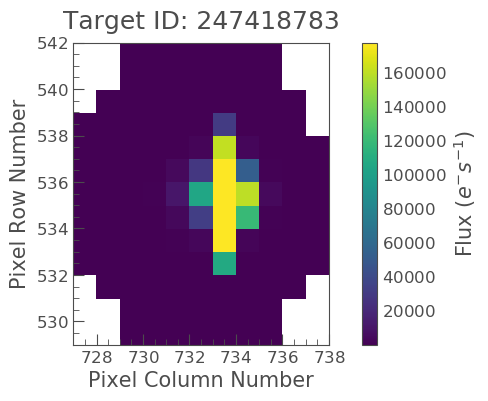

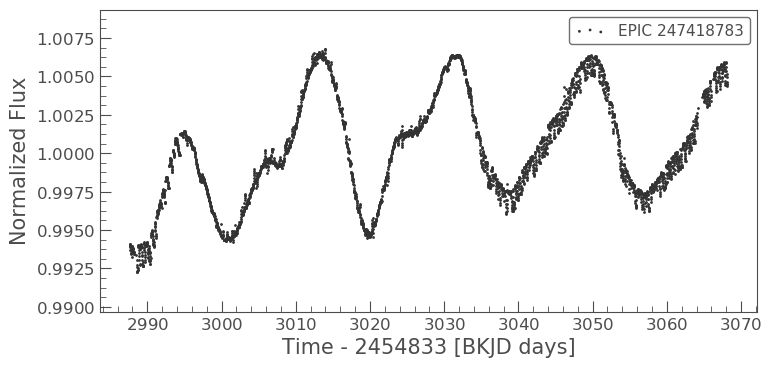

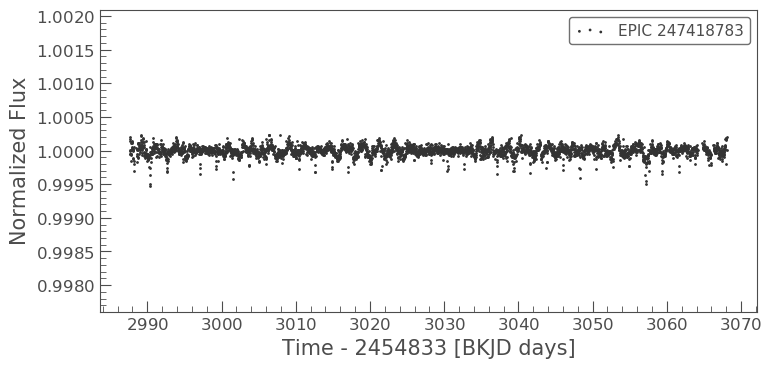

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '247418783'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.remove_nans()
lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=40)
corr_lc_f, trend = corr_lc.flatten(window_length=401, return_trend=True)
corr_lc_f = corr_lc_f.remove_outliers(sigma_lower=50,sigma_upper=3)
corr_lc_f.scatter()

In [4]:
corr_lc_f.time_format = 'bjd'

# Creating a file to store the data
f = open("247418783.txt", "w+")

for i in range(len(corr_lc_f.flux)):
    L = [str(corr_lc_f.time[i]+2454833), " ", str(corr_lc_f.flux[i]), " ", str(corr_lc_f.flux_err[i]), "\n"]
    f.writelines(L)
    
corr_lc_f.time_format = 'bkjd'

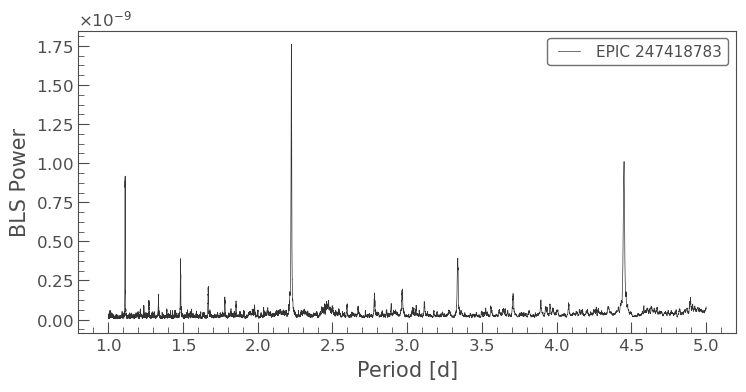

In [6]:
pg = corr_lc_f.to_periodogram("bls", minimum_period=1, maximum_period=5, frequency_factor=5, duration=0.05)
pg.plot();

(<Time object: scale='tdb' format='jd' value=2457822.05323195>,
 <Quantity 2.22556333 d>)

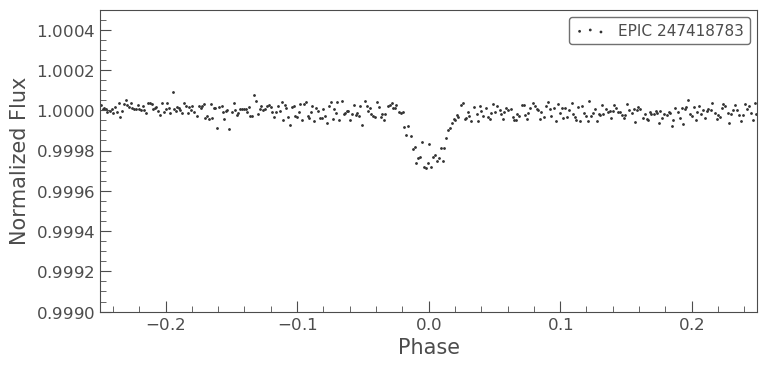

In [11]:
lc_transit = corr_lc_f.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(5)
lc_transit.scatter()
plt.xlim([-0.25, 0.25]);
plt.ylim([0.999, 1.0005]);
pg.transit_time_at_max_power+corr_lc_f.astropy_time[0], pg.period_at_max_power,

In [12]:
import math

R_star = 1.039 # in sun's radius
R_star = R_star * 695510000 # in meter

Td_values = lc_transit.time[lc_transit.flux < 0.9998]
Td = 0.02

min_tr = lc_transit.flux[lc_transit.flux < 0.9998].mean()
R_planet = math.sqrt(1-min_tr)*R_star
R_planet = R_planet / R_star # in jupiter's radius

Td , R_planet

(0.02, 0.015852429257729807)

In [22]:
G = 6.67408 * 10**(-11)
P = pg.period_at_max_power.value*86400
M = 0.971*1.98847*10**30
a = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a)**2 - (Td*math.pi/P)**2)) # in radians
b = a * math.cos(i)

a = a / (1.496*10**11) #R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a, i, b

(0.033033976418800445, 81.59168279523253, 0.9999999999975042)

## With batman:

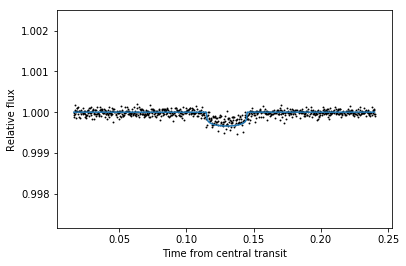

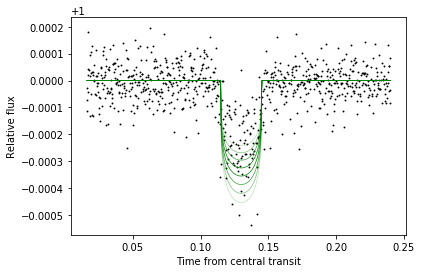

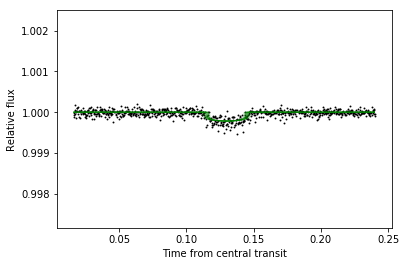

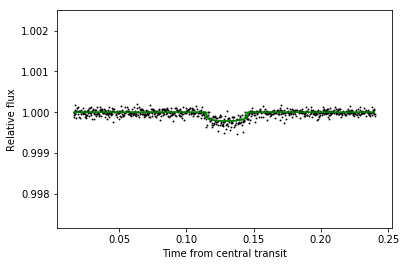

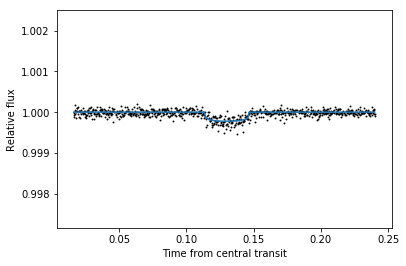

Planet's radius: 0.16917783251178242 [Jupiter radius]
Planet's semi-major axis: 0.047558609182093904 [AU]
Planet's semi-major axis: 88.19555555555556 [degrees]


In [14]:
import batman

params = batman.TransitParams()
params.t0 = 0.13                     #time of inferior conjunction
params.per = abs(lcf[-1].phase - lcf[0].phase)                      #orbital period
params.rp = 0.017                      #planet radius (in units of stellar radii)
params.a = 10                     #semi-major axis (in units of stellar radii)
params.inc = 88                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.3762, 0.27185]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

t = np.linspace(lc_transit[0].phase, lc_transit[-1].phase, len(lc_transit.flux))    #where the transit is

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

#RADIUS

rp_min = params.rp-0.2*params.rp
rp_max = params.rp+0.2*params.rp
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
radii = np.linspace(rp_min, rp_max, 10)
possible_radii = []
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(r - ((rp_max+rp_min)/2))/((rp_max-rp_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_radii.append([r,diff])

        
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.show()
pos_min = 0
for i in range(0,len(possible_radii)-1):
    if (possible_radii[i][1]<possible_radii[i+1][1] and possible_radii[i][1]<possible_radii[pos_min][1]):
        pos_min = i
        
params.rp = possible_radii[pos_min][0]

#SEMI-MAJOR AXIS

a_min = params.a - 0.2*params.a
a_max = params.a + 0.2*params.a
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
axis = np.linspace(a_min, a_max, 10)
possible_axis = []
for a in axis:
        params.a = a                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(a - ((a_max+a_min)/2))/((a_max-a_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_axis.append([a,diff])

plt.show()
pos_min = 0
for i in range(0,len(possible_axis)-1):
    if (possible_axis[i][1]<possible_axis[i+1][1] and possible_axis[i][1]<possible_axis[pos_min][1]):
        pos_min = i

params.a = possible_axis[pos_min][0]

#INCLINATION

i_min = params.inc - 0.02*params.inc
i_max = params.inc + 0.02*params.inc
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
incl = np.linspace(i_min, i_max, 10)
possible_inc = []
for i in incl:
        params.inc = i                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(i - ((i_max+i_min)/2))/((i_max-i_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_inc.append([i,diff])

plt.show()
pos_min = 0
for i in range(0,len(possible_inc)-1):
    if (possible_inc[i][1]<possible_inc[i+1][1] and possible_inc[i][1]<possible_inc[pos_min][1]):
        pos_min = i

params.i = possible_inc[pos_min][0]

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

print("Planet's radius: " + str(possible_radii[pos_min][0]/0.102719) + " [Jupiter radius]")
print("Planet's semi-major axis: " + str(possible_axis[pos_min][0]/214.93946938362) + " [AU]")
print("Planet's semi-major axis: " + str(possible_inc[pos_min][0]) + " [degrees]")

## Using ExoFAST:

Transit fit:  
Chi^2/dof = 1.2244235e-05  
Scaling errors by 0.0034995061  
RMS of residuals = 8.9373305e-05  

Combined fit:  
Chi^2 of Transit data = 0.0014743595 (3549 data points)  
Chi^2 of Priors = 0.00010663929 (7 priors)  
Chi^2/dof = 1.2656008e-05     
    

| symbol | parameter                         | units   | value       |
|--------|-----------------------------------|---------|-------------|
| P      | Period                            | days    | 2.225298    |
| a      | Semi-Major Axis                   | AU      | 0.033098    |
| Rp     | Planet Radius                     | Rj      | 0.141900    |
| Teq    | Equilibrium Temperature           | K       | 1403.365415 |
| u1     | Linear Limb-Darkening Coeff       | none    | 0.454683    |
| u2     | Quadratic Limb-Darkening Coeff    | none    | 0.232308    |
| i      | Inclination                       | degrees | 84.999995   |
| b      | Impact Parameter                  | none    | 0.674263    |
| delta  | Transit Depth                     | none    | 0.000251    |
| TFWHM  | FWHM Duration                     | days    | 0.067966    |
| tau    | Ingress/Egress Duration           | days    | 0.001982    |
| T14    | Total Duration                    | days    | 0.069948v    |